![dvd_image](dvd_image.jpg)

A DVD rental company needs your help! They want to figure out how many days a customer will rent a DVD for based on some features and has approached you for help. They want you to try out some regression models which will help predict the number of days a customer will rent a DVD for. The company wants a model which yeilds a MSE of 3 or less on a test set. The model you make will help the company become more efficient inventory planning.

The data they provided is in the csv file `rental_info.csv`. It has the following features:
- `"rental_date"`: The date (and time) the customer rents the DVD.
- `"return_date"`: The date (and time) the customer returns the DVD.
- `"amount"`: The amount paid by the customer for renting the DVD.
- `"amount_2"`: The square of `"amount"`.
- `"rental_rate"`: The rate at which the DVD is rented for.
- `"rental_rate_2"`: The square of `"rental_rate"`.
- `"release_year"`: The year the movie being rented was released.
- `"length"`: Lenght of the movie being rented, in minuites.
- `"length_2"`: The square of `"length"`.
- `"replacement_cost"`: The amount it will cost the company to replace the DVD.
- `"special_features"`: Any special features, for example trailers/deleted scenes that the DVD also has.
- `"NC-17"`, `"PG"`, `"PG-13"`, `"R"`: These columns are dummy variables of the rating of the movie. It takes the value 1 if the move is rated as the column name and 0 otherwise. For your convinience, the reference dummy has already been dropped.

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Step 1: Load the dataset
df = pd.read_csv("rental_info.csv")

# Step 2: Create the 'rental_length_days' column
df['rental_date'] = pd.to_datetime(df['rental_date'])
df['return_date'] = pd.to_datetime(df['return_date'])
df['rental_length_days'] = (df['return_date'] - df['rental_date']).dt.days

# Step 3: Create dummy variables for 'special_features'
df['deleted_scenes'] = df['special_features'].apply(lambda x: 1 if 'Deleted Scenes' in str(x) else 0)
df['behind_the_scenes'] = df['special_features'].apply(lambda x: 1 if 'Behind the Scenes' in str(x) else 0)

# Step 4: Create the feature matrix X, avoiding columns that leak data about the target
# Drop columns that contain target information or unnecessary details
X = df.drop(columns=['rental_date', 'return_date', 'special_features', 'rental_length_days'])

# Define the target variable y
y = df['rental_length_days']

# Step 5: Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

# Step 6: Try different regression models and find one with MSE < 3
# Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)
mse_linear = mean_squared_error(y_test, y_pred_linear)

# Random Forest Regressor
rf_model = RandomForestRegressor(random_state=9)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)

# Step 7: Choose the best model with MSE < 3
if mse_linear < 3:
    best_model = linear_model
    best_mse = mse_linear
elif mse_rf < 3:
    best_model = rf_model
    best_mse = mse_rf
else:
    print("No model met the MSE requirement.")

# Output the best model and its MSE
print("Best Model:", best_model)
print("Best MSE on test set:", best_mse)


Best Model: LinearRegression()
Best MSE on test set: 2.9417238646975883


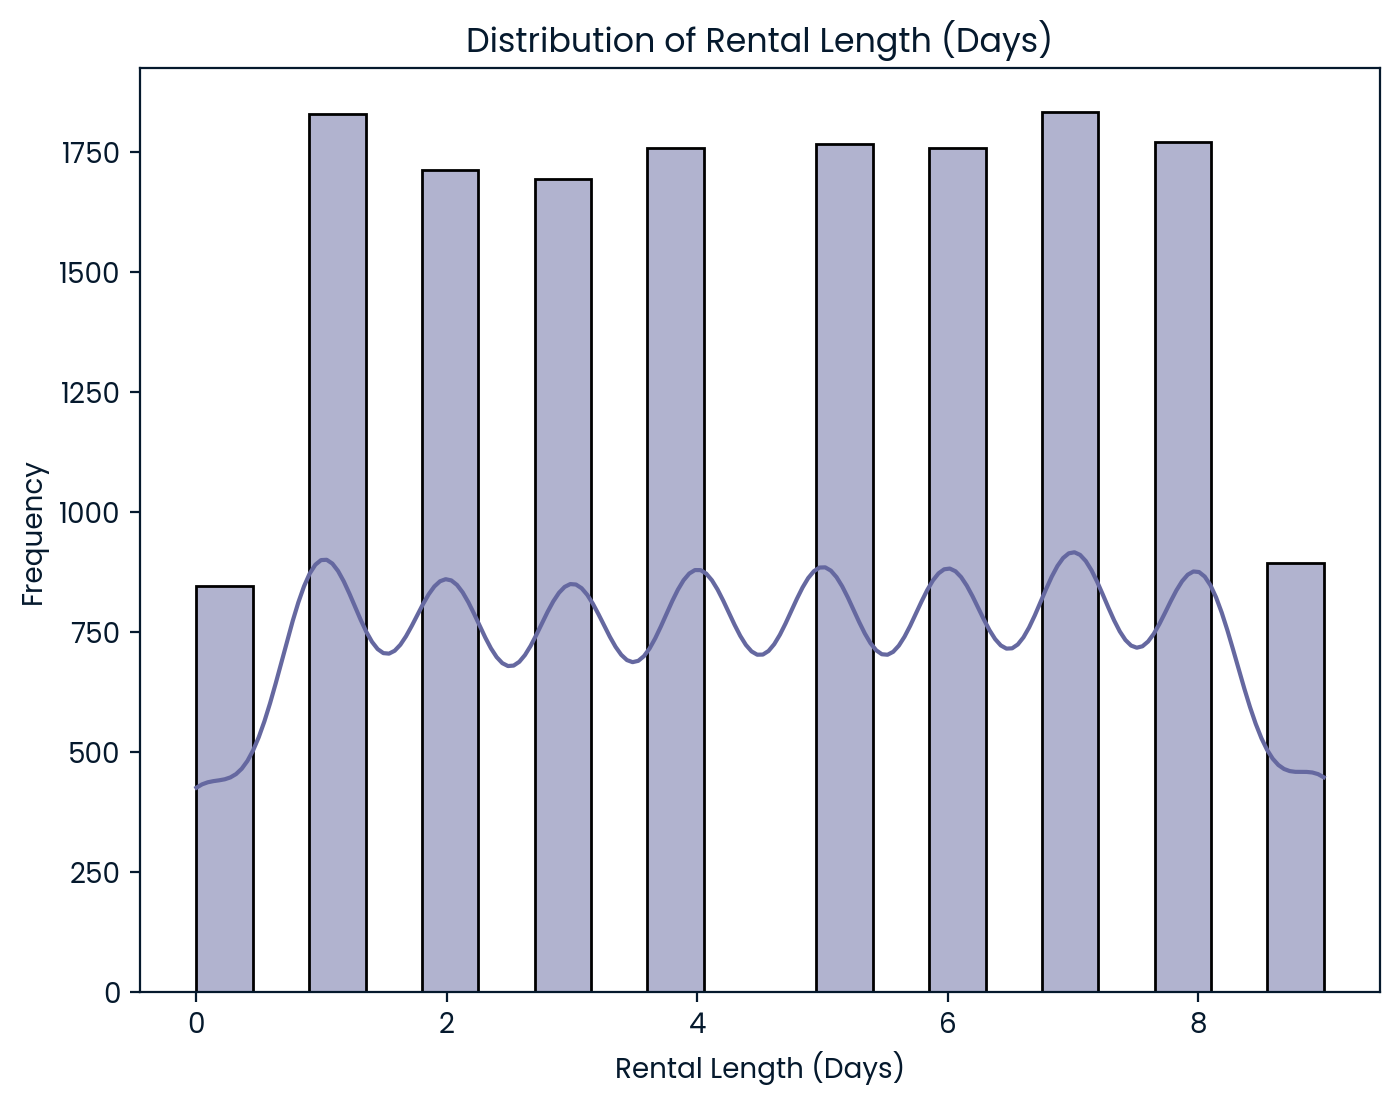

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.histplot(df['rental_length_days'], bins=20, kde=True)
plt.title('Distribution of Rental Length (Days)')
plt.xlabel('Rental Length (Days)')
plt.ylabel('Frequency')
plt.show()


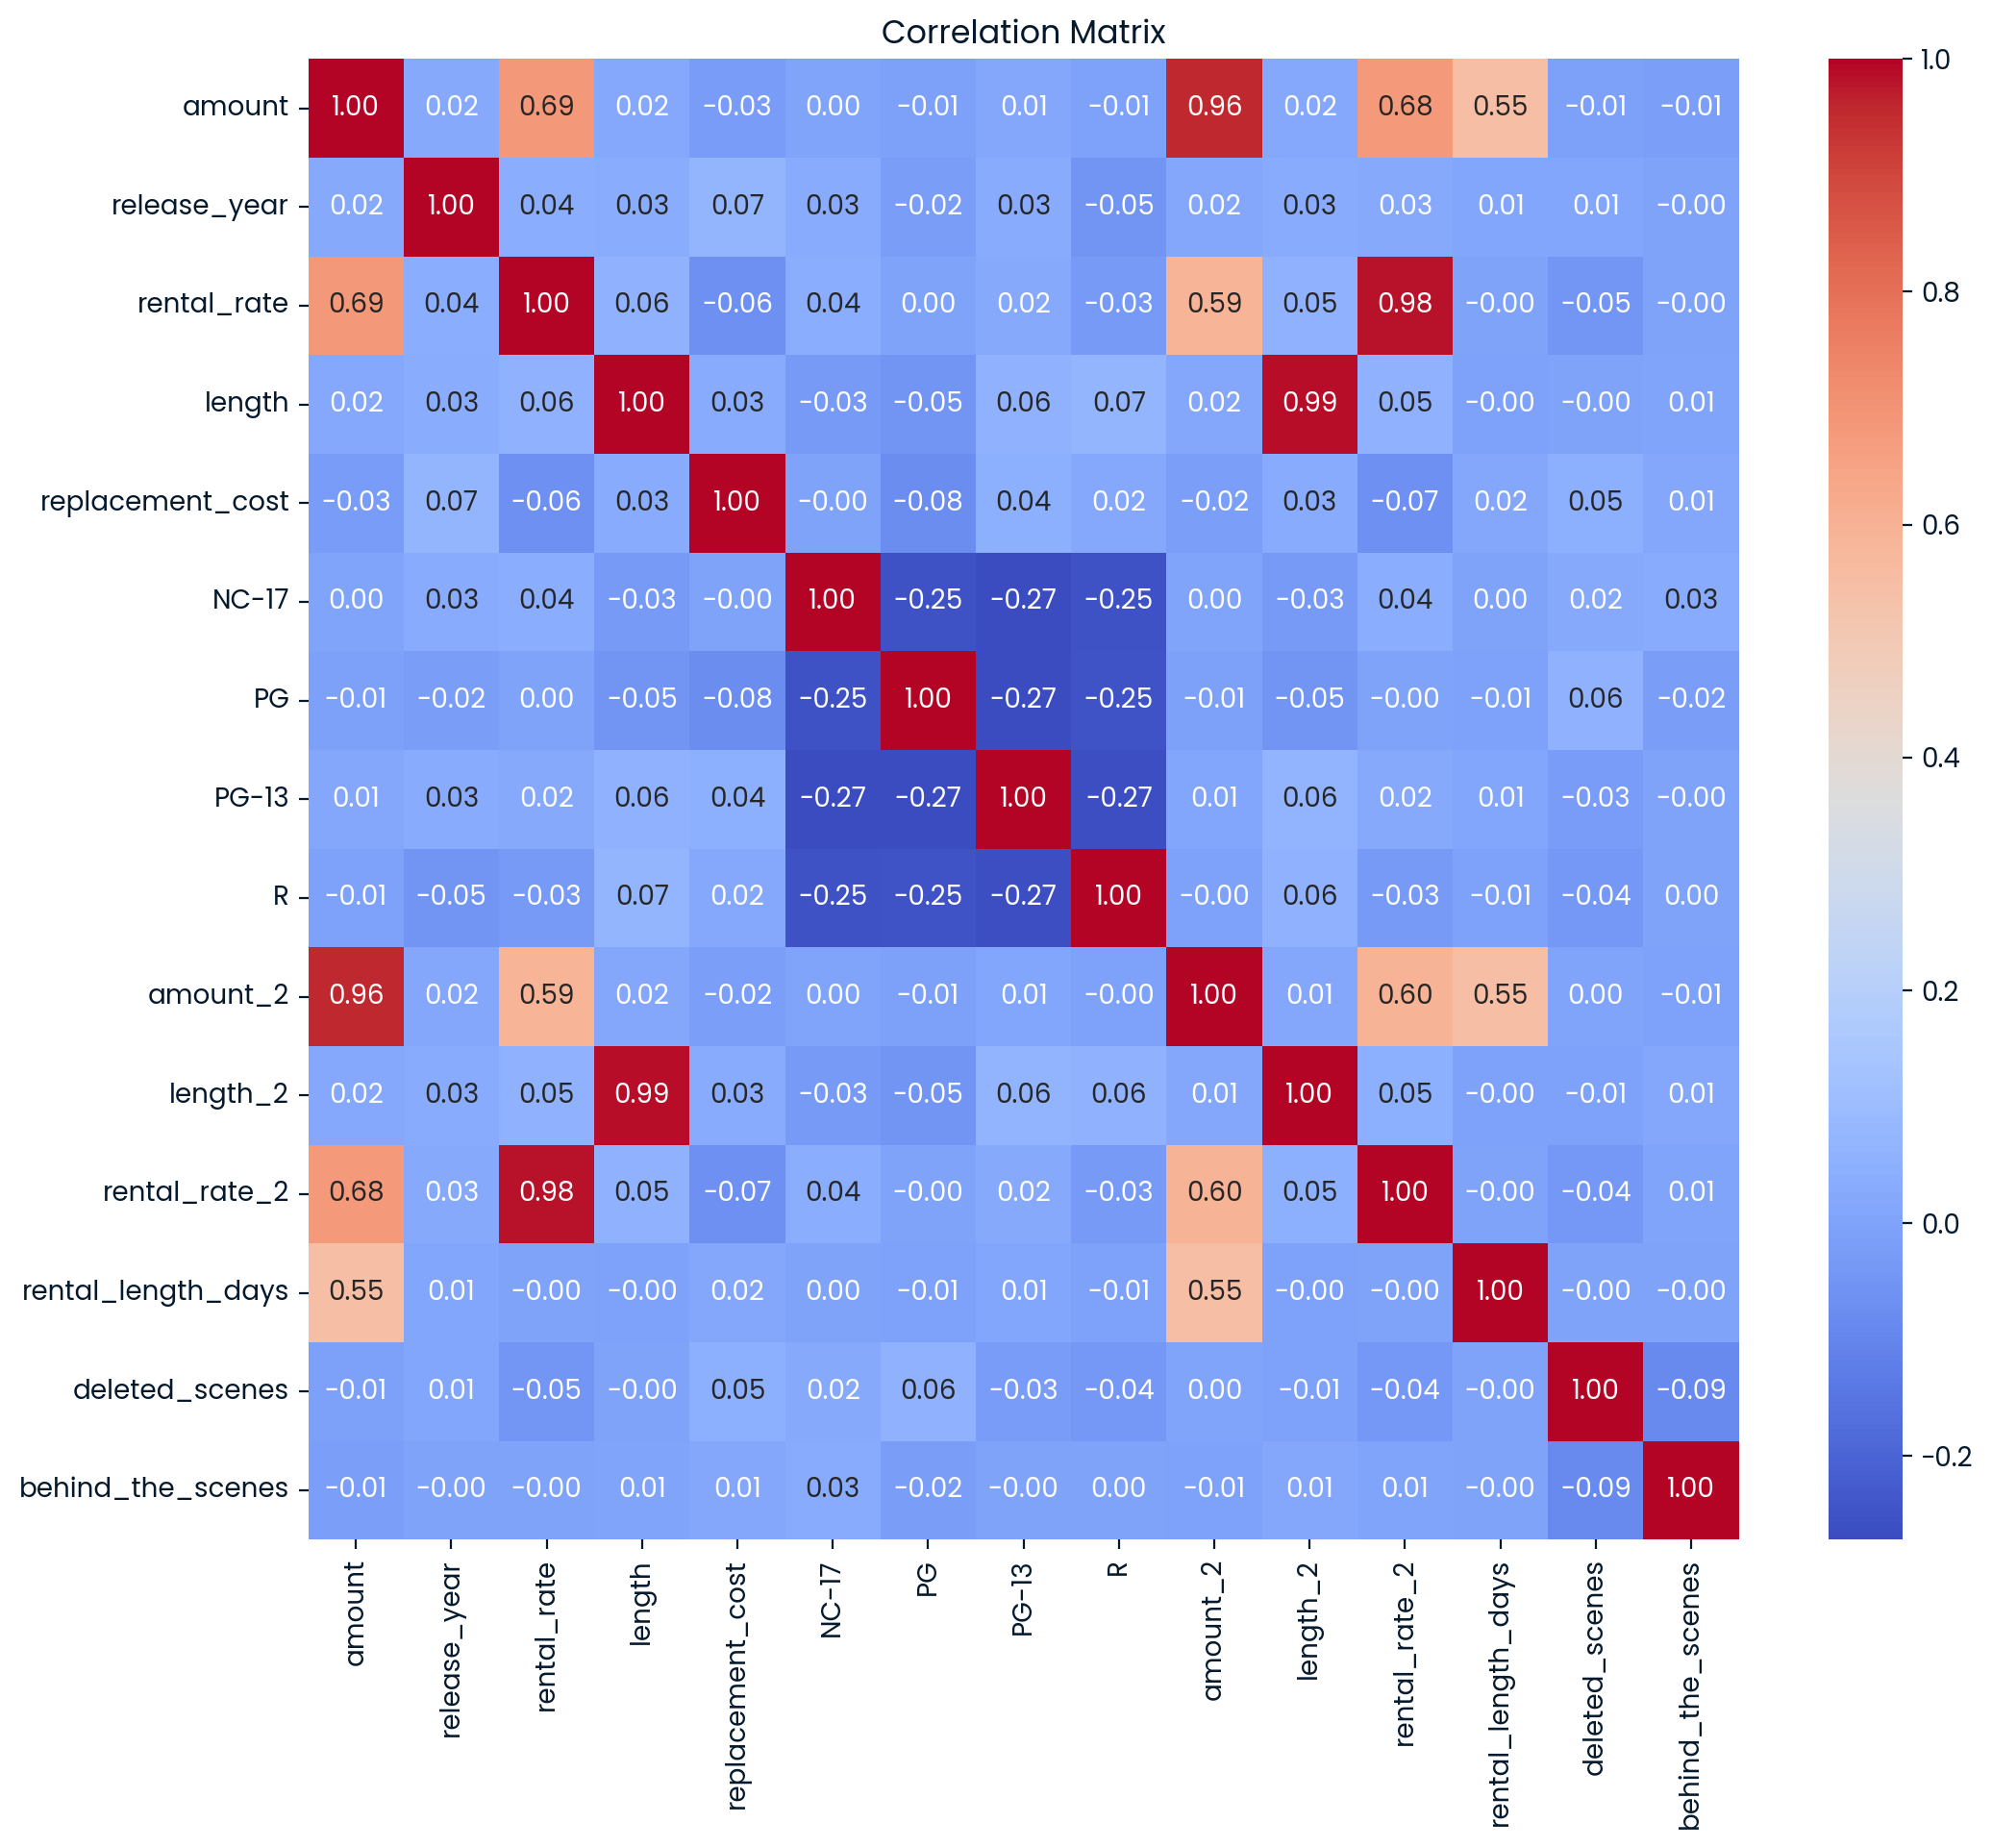

In [4]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


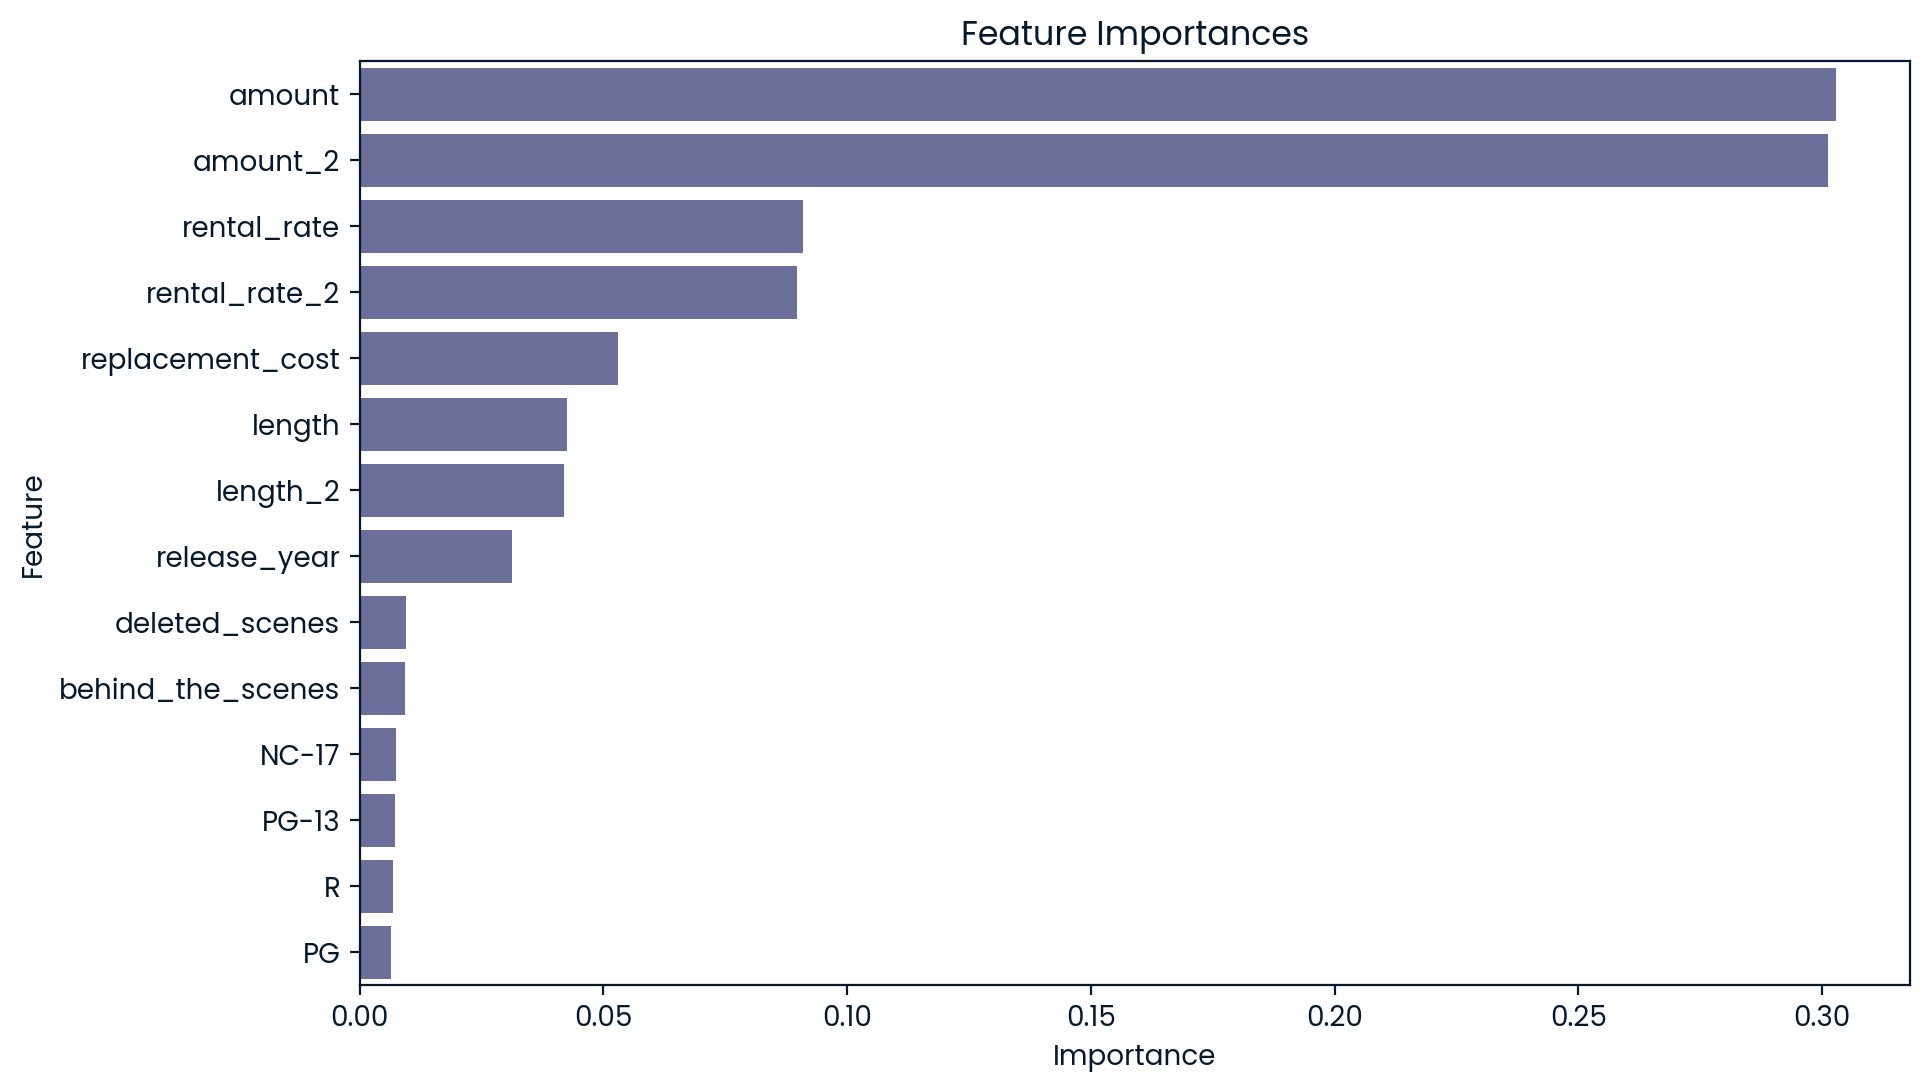

In [5]:
importances = rf_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances')
plt.show()


In [6]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=9), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
best_mse = mean_squared_error(y_test, best_model.predict(X_test))

print("Best Model after tuning:", best_model)
print("Best MSE on test set after tuning:", best_mse)


Best Model after tuning: RandomForestRegressor(max_depth=20, n_estimators=200, random_state=9)
Best MSE on test set after tuning: 2.0250206688633443


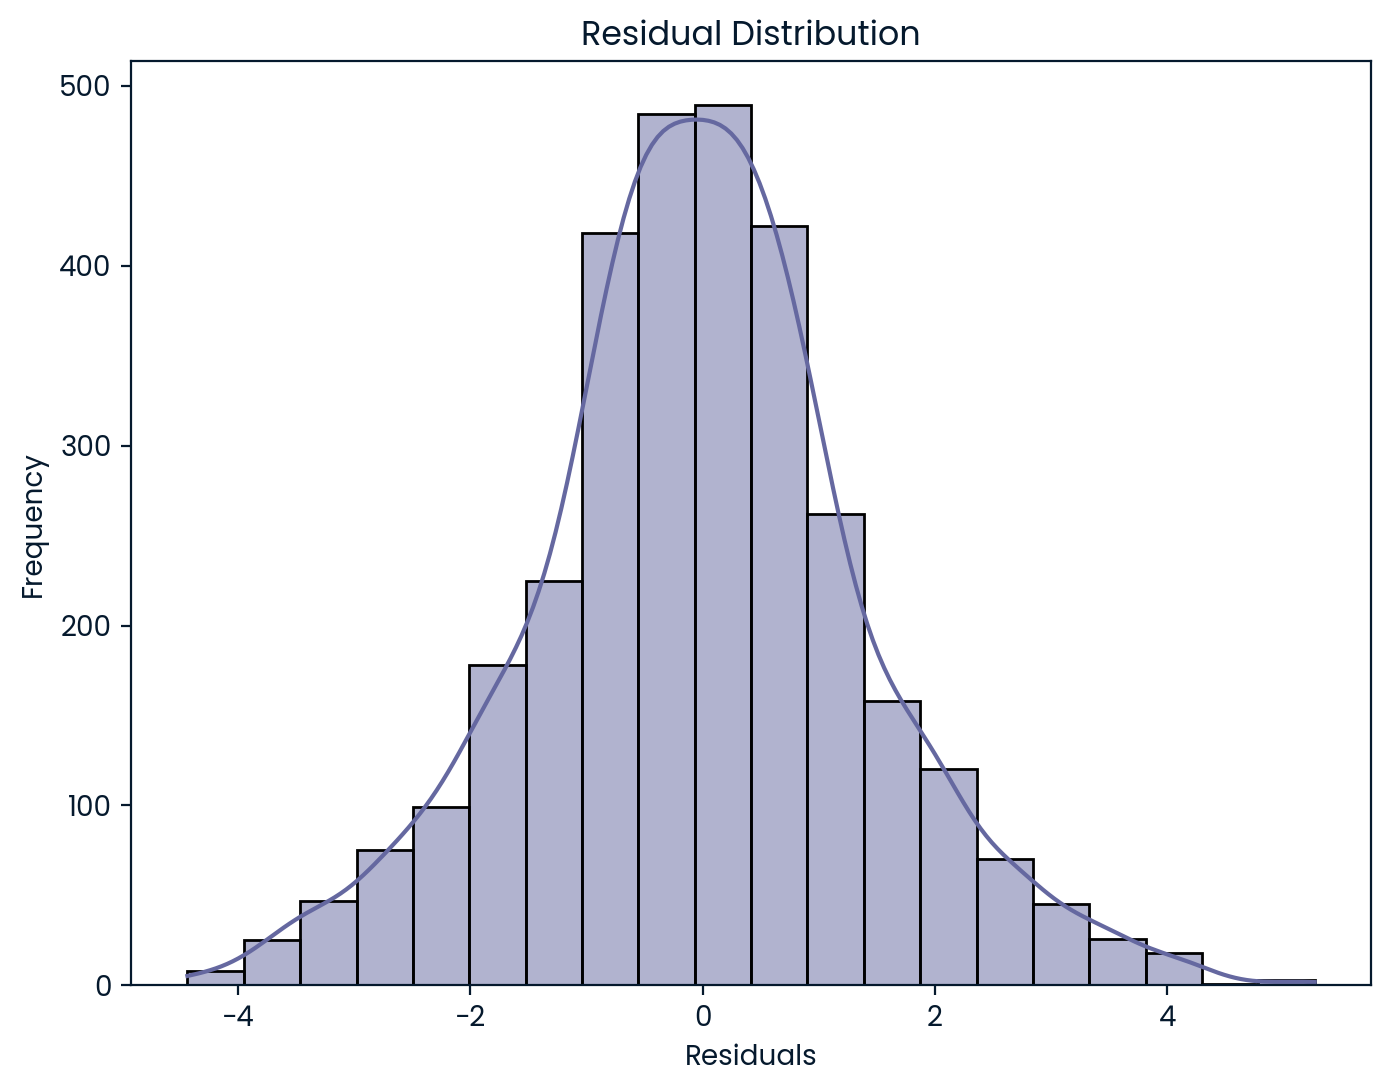

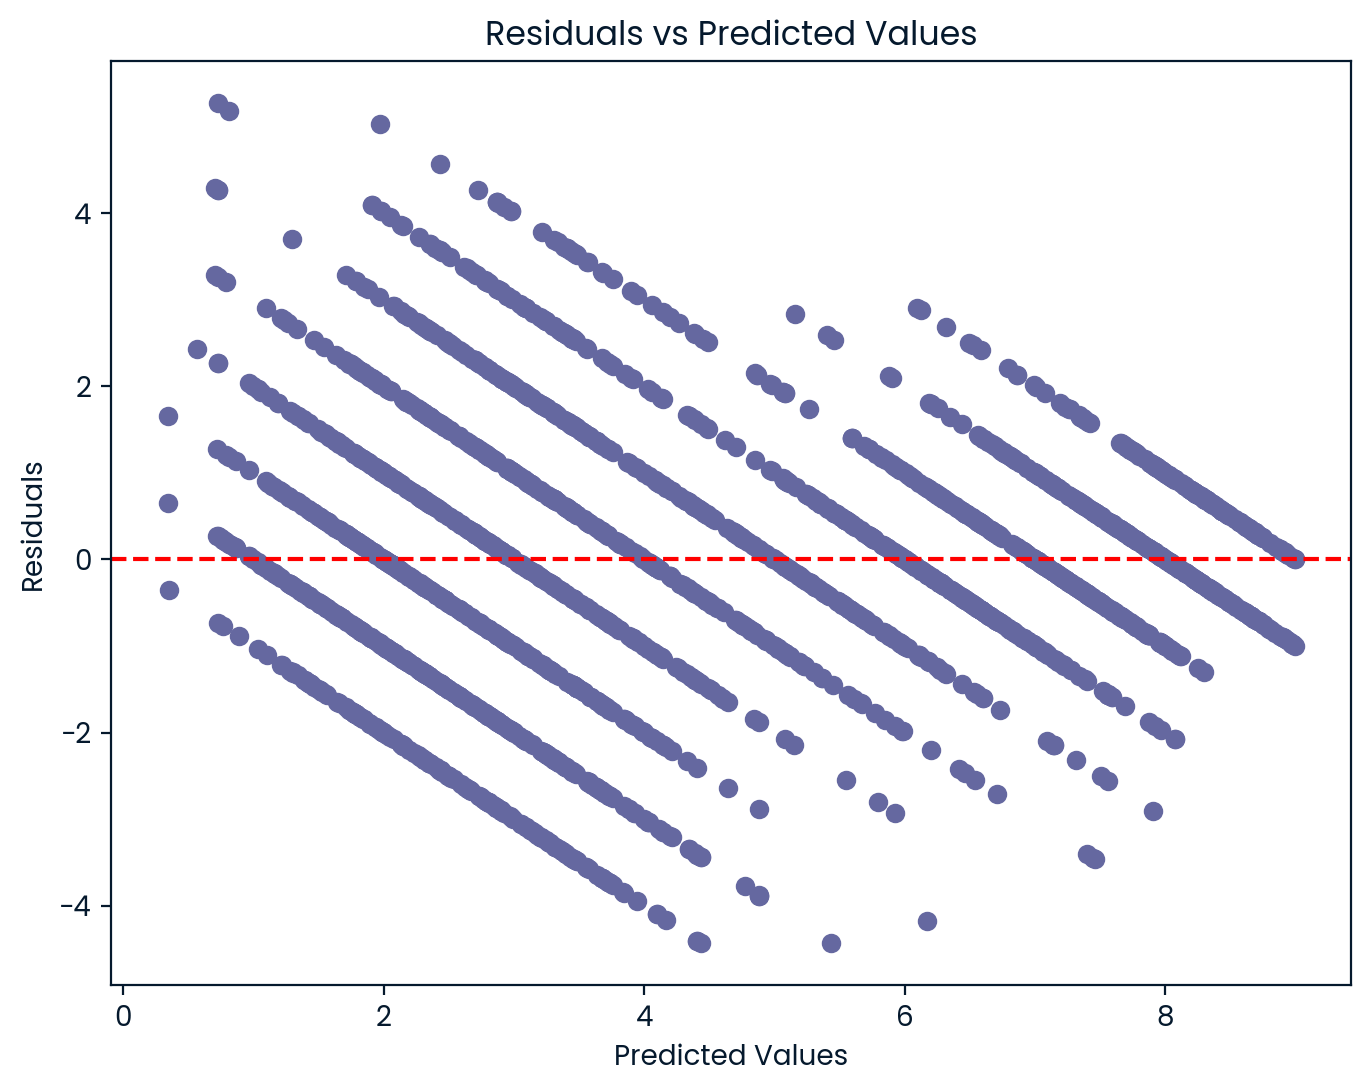

In [7]:
y_pred = best_model.predict(X_test)
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=20, kde=True)
plt.title("Residual Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted Values")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()
